# Instrument Parameter Sensitivity Studies

## Derived from Requirement Derivation, L1-1 Global Point Sources



In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
include("../forwardModel.jl")
using CairoMakie, DelimitedFiles, Statistics, Interpolations, NCDatasets, InstrumentOperator, LinearAlgebra
using Unitful, UnitfulEquivalences
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
include(joinpath(dirname(pathof(CarbonI)), "readSun.jl"))
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))
using LaTeXStrings
set_theme!(theme_ggplot2())

  Activating project at `~/src/CarbonI-drt`


In [2]:
# Define numbers from L1 Requirements - this part duplicates Level1-Req-1.ipynb

# Flux limits:
flux_detect_ch4_req = 175.0u"kg/hr"    # in kg CH4/hr
flux_detect_co2_req = 100e3u"kg/hr"    # in kg CO2/hr
flux_detect_co_req  = 1.75e3u"kg/hr"   # in kg CO/hr

# GSD, required and CBE
gsd_req  = [400.0u"m", 400.0u"m"]      # in m
gsd_cbe  = [303.0u"m", 345.0u"m"]      # in m

2-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
 303.0 m
 345.0 m

In [3]:
# Effective Pixel Sizes
req_pix = sqrt(prod(gsd_req));
cbe_pix = sqrt(prod(gsd_cbe));

In [4]:
# Define constants:
m = CarbonI.molar_mass()
C = CarbonI.Constants()
preFac = C.g * m.air / C.p

# q=2 for detection limits
q = 2.0
# Wind speed for the reference scenario
wind_speed = 2.0u"m/s"
# Value of the prefactor (a constant for a given surface pressure)
@show C.g * m.air / C.p

(C.g * m.air) / C.p = 2.841957e-6 m² mol⁻¹


2.841957e-6 m² mol⁻¹

In [5]:
σ_ch4_req = flux_detect_ch4_req * preFac / req_pix / m.ch4 / wind_speed / q
σ_co2_req = flux_detect_co2_req * preFac / req_pix / m.co2 / wind_speed / q
σ_co_req  = flux_detect_co_req  * preFac / req_pix / m.co  / wind_speed / q

@show uconvert(u"ppb", σ_ch4_req)
@show uconvert(u"ppm", σ_co2_req)
@show uconvert(u"ppb", σ_co_req)

@printf("Required Single Measurement Precision for CH₄ : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_ch4_req)))
@printf("Required Single Measurement Precision for CO₂ : %.3g ppm\n",  ustrip(uconvert(u"ppm", σ_co2_req)))
@printf("Required Single Measurement Precision for CO  : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_co_req)))

uconvert(u"ppb", σ_ch4_req) = 5.383053596477556 ppb
uconvert(u"ppm", σ_co2_req) = 1.1210981879118382 ppm
uconvert(u"ppb", σ_co_req) = 30.82619767493752 ppb
Required Single Measurement Precision for CH₄ : 5.38 ppb
Required Single Measurement Precision for CO₂ : 1.12 ppm
Required Single Measurement Precision for CO  : 30.8 ppb


In [6]:
# Use the reference scenario
scenario = CarbonI.reference_scenario();

# Load CBE specs
cbe_specs = CarbonI.build_instrument("CBE");

# Load Required specs
req_specs = CarbonI.build_instrument("Requirement");

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[187.60953, 195.1012, 201.35501, 208.64655, 216.49673, 222.47076, 227.39767, 230.89746, 235.26309, 242.40393, 250.36801, 259.4926, 268.20334, 272.86224, 273.1006, 270.50668, 266.17313, 261.9602, 257.33777, 253.24066, 249.31465, 244.15125, 240.6859, 238.05463, 235.39015, 231.98767, 228.57484, 226.37009, 223.45546, 222.34386, 220.49219, 217.9867, 216.47473, 214.98712, 213.25296, 210.32483, 207.75937, 206.41586, 207.52103, 209.51251, 210.57042, 216.20634, 224.16565, 232.26859, 240.40128, 247.10199, 252.58617, 255.18288, 257.9303, 263.41864, 267.52917, 272.1396, 276.66675, 280.92175, 284.42505, 286.95496, 289.00113, 290.2957, 290.15128, 289.2277, 289.0184, 290.03265, 291.2717, 292.5702, 293.89865, 295.23, 296.56677, 297.8983, 299.22983, 300.5767, 301.94052, 303.46246]


In [7]:
# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

In [8]:
# Get reflectance here
wll = req_specs.modelling_wl;
refl_req   = scenario.surface_albedo(wll);
refl_cbe   = scenario.surface_albedo(wll);

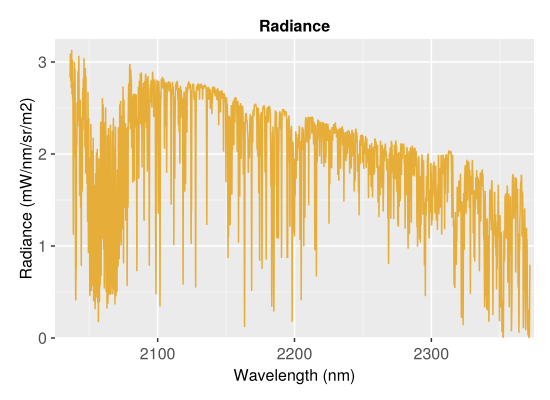

In [36]:
# Illustrate the radiance at sensor using high-spectral-resolution sampling
# Construct a forward model for the reference case

include("/Users/drt/src/CarbonI-drt/src/Requirements/instrument.jl")

fine_inst = build_instrument(
        FPA_quantum_efficiency = 0.88,
        bench_efficiency = 0.657,
        readout_noise = 101.5, # Includes quantization error
        dark_current = 3e3u"1/s",
        SSI = 0.1u"nm",
        FWHM = 0.1,
        FWHM_gaussian = 0.1,
        lower_wavelength = 2036.0,
        upper_wavelength = 2372.0,
        pixel_size_global = 345u"m",
        pixel_size_target = 34.5u"m"
    )

co2, ch4, h2o, hdo, n2o, co, co2_iso2, c2h6 = CarbonI.loadXSModels();
DS = Dataset(CarbonI.solar_file)
wlSol = 1e3*DS["wl"][:]
solar_irr = 1e3*DS["solar_irr"][:] # convert to mW/m2/nm
close(DS) 
hitran_array = (co2, h2o, ch4, co, n2o, hdo, co2_iso2, c2h6);
	
# Precompute the cross sections:
σ_matrix_hr = CarbonI.compute_profile_crossSections(scenario.profile_hr, hitran_array , req_specs.modelling_wl);

nL = length(scenario.profile_hr.T)
    
vmr_co2 = zeros(nL) .+ 407e-6
vmr_ch4 = zeros(nL) .+ 1.8e-6
vmr_ch4[1:3] .= 1.4e-6
vmr_h2o = scenario.profile_hr.vcd_h2o ./ scenario.profile_hr.vcd_dry
vmr_co  = zeros(nL) .+ 100e-9
vmr_n2o = zeros(nL) .+ 337e-9
vmr_n2o[1:3] .= 100e-9
vmr_hdo = vmr_h2o * 0.9
vmr_c2h6 = zeros(nL) .+ 1.0e-9
vmrs = [vmr_co2, vmr_h2o, vmr_ch4,vmr_co, vmr_n2o, vmr_hdo, vmr_co2, vmr_c2h6];

sol  = CubicSplineInterpolation(range(wlSol[1],wlSol[end], length=length(wlSol)),solar_irr, extrapolation_bc=Interpolations.Flat());

n_layers = 10;
profile, σ_matrix, indis, gasProfiles = CarbonI.reduce_profile(n_layers, scenario.profile_hr, σ_matrix_hr,vmrs)
nLeg = 10
xPoly = zeros(nLeg).+eps()
xPoly[1] = 1.0
x = [reduce(vcat,gasProfiles) ; xPoly ];

f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance (mW/nm/sr/m2)",  title="Radiance")
q=forward_model_x_(x, 
						 sun=solarIrr_req, 
						 instrument=fine_inst.instrument_kernel,
			             reflectance=refl_req, 
			             sza=scenario.sza, 
			             σ_matrix=σ_matrix, 
					     profile=profile,
			             wl=fine_inst.modelling_wl)

q2=forward_model_x_(x, 
						 sun=solarIrr_req, 
						 instrument=req_specs.instrument_kernel,
			             reflectance=refl_req, 
			             sza=scenario.sza, 
			             σ_matrix=σ_matrix, 
					     profile=profile,
			             wl=req_specs.modelling_wl)

lines!(ax,fine_inst.instrument_wl,q,color=CarbonI_colors[1],label="Simulated Reflected Radiance")
#axislegend(ax,position = :lt)
xlims!(ax,2025,2375)
ylims!(ax,0,3.25)
save("/Users/drt/src/CarbonI-drt/plots/final/SimulatedRadiance.pdf",f)
f

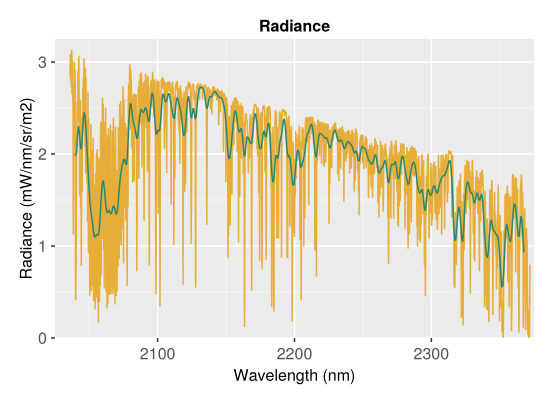

In [35]:
# Illustrate the resampling
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance (mW/nm/sr/m2)",  title="Radiance")
lines!(ax,fine_inst.instrument_wl,q,color=CarbonI_colors[1],label="Radiance")
lines!(ax,req_specs.instrument_wl,q2,color=CarbonI_colors[3],label="Radiance")
xlims!(ax,2025,2375)
ylims!(ax,0,3.25)
save("/Users/drt/src/CarbonI-drt/plots/final/ResampledRadiance.pdf",f)
f

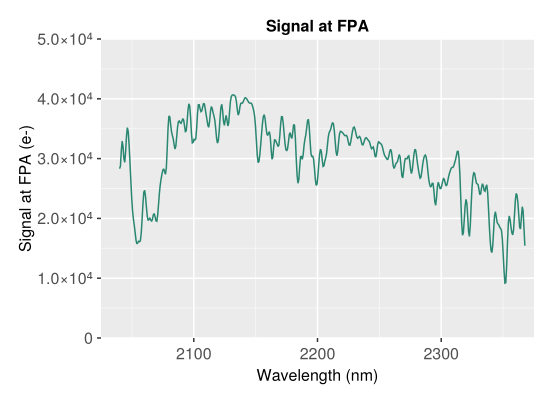

In [34]:
# Show signal at FPA
signal = InstrumentOperator.photons_at_fpa(ins_req, (req_specs.instrument_wl)u"nm", (q2)u"mW/m^2/nm/sr")
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Signal at FPA (e-)",  title="Signal at FPA")
lines!(ax,req_specs.instrument_wl,signal,color=CarbonI_colors[3],label="Signal")
xlims!(ax,2025,2375)
ylims!(ax,0,50000)
save("/Users/drt/src/CarbonI-drt/plots/final/SignalAtFPA.pdf",f)
f

In [38]:
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) 

(Dict{Any, Any}("ch4" => 10.169267298478433, "h2o" => 25789.69301820567, "co" => 42.66610353980502, "n2o" => 19.752352244629314, "hdo" => 174588.22378418813, "c2h6" => 25.612590001898933, "co2" => 2197.7052471288075, "co213" => 15617.578884458415), [2.9347659998209368, 2.9244170677547796, 2.7861478511231725, 2.4585745514104835, 2.370877958101474, 2.101959738259234, 1.5845150034998492, 1.8872018549331298, 2.4874269186033615, 2.544563990075057  …  1.5793954880093595, 1.3564284056202263, 0.9376469195457674, 0.8197518012739107, 0.7713671562665959, 0.7435625617427715, 0.689547995241922, 0.3293453713454478, 0.22911025798947213, 0.540061696871597])

In [40]:
sqrtN = sqrt(req_specs.coadd_rate)

3.1622776601683795

In [41]:
@printf("Expected Single Measurement Precision for CH₄ : %.3g ppb\n",  error_cbe["ch4"]/sqrtN)
@printf("Expected Single Measurement Precision for CO₂ : %.3g ppm\n",  error_cbe["co2"]/1000/sqrtN)
@printf("Expected Single Measurement Precision for CO  : %.3g ppb\n",  error_cbe["co"]/sqrtN)
@printf("Expected Single Measurement Precision for N₂O  : %.3g ppb\n",  error_cbe["n2o"]/sqrtN)

Expected Single Measurement Precision for CH₄ : 3.22 ppb
Expected Single Measurement Precision for CO₂ : 0.695 ppm
Expected Single Measurement Precision for CO  : 13.5 ppb
Expected Single Measurement Precision for N₂O  : 6.25 ppb


In [42]:
# Now get total efficiency at different F-numbers

fnumbers = 2.0:0.1:3
gas_errors_fnumber_100 = zeros(4,length(fnumbers))
gas_errors_fnumber_120 = zeros(4,length(fnumbers))
for (i,fnumber) in enumerate(fnumbers)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    efficiency = req_specs.FPA_quantum_efficiency * req_specs.bench_efficiency
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    gas_errors_fnumber_100[1,i] = error_varied_100["ch4"]/sqrt(req_specs.coadd_rate)
    gas_errors_fnumber_120[1,i] = error_varied_120["ch4"]/sqrt(req_specs.coadd_rate) 
    gas_errors_fnumber_100[2,i] = error_varied_100["co2"]/sqrt(req_specs.coadd_rate)
    gas_errors_fnumber_120[2,i] = error_varied_120["co2"]/sqrt(req_specs.coadd_rate) 
    gas_errors_fnumber_100[3,i] = error_varied_100["co"]/sqrt(req_specs.coadd_rate)
    gas_errors_fnumber_120[3,i] = error_varied_120["co"]/sqrt(req_specs.coadd_rate) 
    gas_errors_fnumber_100[4,i] = error_varied_100["n2o"]/sqrt(req_specs.coadd_rate)
    gas_errors_fnumber_120[4,i] = error_varied_120["n2o"]/sqrt(req_specs.coadd_rate) 
    println(gas_errors_fnumber_100[1,i])
end

# Now get total efficiency at different Dark Currents

darkcurrents = 2000.0:1000.0:10000.0
gas_errors_darkcurrent_100 = zeros(4,length(darkcurrents))
gas_errors_darkcurrent_120 = zeros(4,length(darkcurrents))
for (i,darkcurrent) in enumerate(darkcurrents)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    efficiency = req_specs.FPA_quantum_efficiency * req_specs.bench_efficiency
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), (darkcurrent)u"s^-1"); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), (darkcurrent)u"s^-1"); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    gas_errors_darkcurrent_100[1,i] = error_varied_100["ch4"]/sqrt(req_specs.coadd_rate)
    gas_errors_darkcurrent_120[1,i] = error_varied_120["ch4"]/sqrt(req_specs.coadd_rate) 
    gas_errors_darkcurrent_100[2,i] = error_varied_100["co2"]/sqrt(req_specs.coadd_rate)
    gas_errors_darkcurrent_120[2,i] = error_varied_120["co2"]/sqrt(req_specs.coadd_rate) 
    gas_errors_darkcurrent_100[3,i] = error_varied_100["co"]/sqrt(req_specs.coadd_rate)
    gas_errors_darkcurrent_120[3,i] = error_varied_120["co"]/sqrt(req_specs.coadd_rate) 
    gas_errors_darkcurrent_100[4,i] = error_varied_100["n2o"]/sqrt(req_specs.coadd_rate)
    gas_errors_darkcurrent_120[4,i] = error_varied_120["n2o"]/sqrt(req_specs.coadd_rate) 
    println(gas_errors_darkcurrent_100[1,i])
end

# Now get total efficiency at different integration times

integrations = (37.0:10.0:77.0)
gas_errors_integration_100 = zeros(4,length(integrations))
gas_errors_integration_120 = zeros(4,length(integrations))
for (i,integration) in enumerate(integrations)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    efficiency = req_specs.FPA_quantum_efficiency * req_specs.bench_efficiency
    ins_req_100 = InstrumentOperator.createGratingNoiseModel((integration)u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel((integration)u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    gas_errors_integration_100[1,i] = error_varied_100["ch4"]/sqrt(req_specs.coadd_rate)
    gas_errors_integration_120[1,i] = error_varied_120["ch4"]/sqrt(req_specs.coadd_rate) 
    gas_errors_integration_100[2,i] = error_varied_100["co2"]/sqrt(req_specs.coadd_rate)
    gas_errors_integration_120[2,i] = error_varied_120["co2"]/sqrt(req_specs.coadd_rate) 
    gas_errors_integration_100[3,i] = error_varied_100["co"]/sqrt(req_specs.coadd_rate)
    gas_errors_integration_120[3,i] = error_varied_120["co"]/sqrt(req_specs.coadd_rate) 
    gas_errors_integration_100[4,i] = error_varied_100["n2o"]/sqrt(req_specs.coadd_rate)
    gas_errors_integration_120[4,i] = error_varied_120["n2o"]/sqrt(req_specs.coadd_rate) 
    println(gas_errors_integration_100[1,i])
end

3.809528848641555
4.036123901810972
4.268758112638914
4.507557906659343
4.752645665523157
5.004139242063944
5.262151655285551
5.52679092248281
5.7981599952001375
6.076356773156526
6.361474176044279
4.260186688743586
4.263045934709179
4.265903074312356
4.268758112638914
4.271611054752941
4.274461905696544
4.277310670490261
4.280157354133073
4.283001961602451
5.600122446255255
4.806066538734728
4.268758112638914
3.8770539149367846
3.5765584243871884


In [53]:
ch4_req_ppb = ustrip(uconvert(u"ppb", σ_ch4_req))
co2_req_ppb = ustrip(uconvert(u"ppb", σ_co2_req))
co_req_ppb  = ustrip(uconvert(u"ppb", σ_co_req))

30.82619767493752

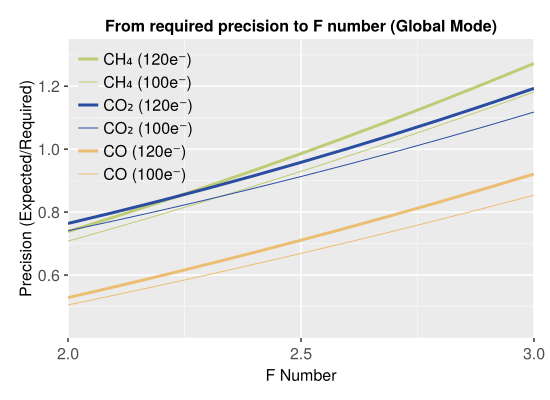

In [47]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="F Number", ylabel="Precision (Expected/Required)",  title="From required precision to F number (Global Mode)")
# For CH4 (100 and 120e-)
lines!(ax, fnumbers, gas_errors_fnumber_120[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=3, label="CH₄ (120e⁻)")
lines!(ax, fnumbers, gas_errors_fnumber_100[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=1, label="CH₄ (100e⁻)")
# For CO2 (100 and 120e-)
lines!(ax, fnumbers, gas_errors_fnumber_120[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=3, label="CO₂ (120e⁻)")
lines!(ax, fnumbers, gas_errors_fnumber_100[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=1, label="CO₂ (100e⁻)")
# For CO (100 and 120e-)
lines!(ax, fnumbers, gas_errors_fnumber_120[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=3, label="CO (120e⁻)")
lines!(ax, fnumbers, gas_errors_fnumber_100[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=1, label="CO (100e⁻)")
xlims!(ax,2.0,3)
ylims!(ax,0.4,1.35)
axislegend(ax,position = :lt)
save("../../plots/final/SensitivityStudy_Fnumber.pdf",f)
f

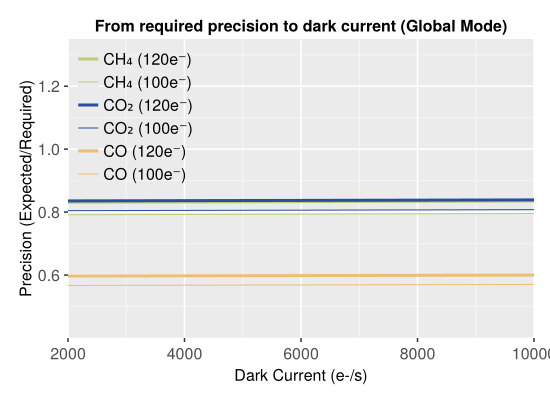

In [49]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Dark Current (e-/s)", ylabel="Precision (Expected/Required)",  title="From required precision to dark current (Global Mode)")
# For CH4 (100 and 120e-)
lines!(ax, darkcurrents, gas_errors_darkcurrent_120[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=3, label="CH₄ (120e⁻)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_100[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=1, label="CH₄ (100e⁻)")
# For CO2 (100 and 120e-)
lines!(ax, darkcurrents, gas_errors_darkcurrent_120[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=3, label="CO₂ (120e⁻)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_100[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=1, label="CO₂ (100e⁻)")
# For CO (100 and 120e-)
lines!(ax, darkcurrents, gas_errors_darkcurrent_120[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=3, label="CO (120e⁻)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_100[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=1, label="CO (100e⁻)")

xlims!(ax,2000,10000)
ylims!(ax,0.4,1.35)
axislegend(ax,position = :lt)
save("../../plots/final/SensitivityStudy_darkcurrent.pdf",f)
f

In [ ]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Dark Current (e-/s)", ylabel="Precision (Expected/Required)",  title="From required precision to dark current (Global Mode)")
# For CH4 (100 and 120e-)
lines!(ax, darkcurrents, gas_errors_darkcurrent_120[4,:], color=CarbonI_colors[7], linewidth=3, label="CH₄ (120e⁻)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_100[4,:], color=CarbonI_colors[7], linewidth=1, label="CH₄ (100e⁻)")
# For CO2 (100 and 120e-)
lines!(ax, darkcurrents, gas_errors_darkcurrent_120[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=3, label="CO₂ (120e⁻)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_100[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=1, label="CO₂ (100e⁻)")
# For CO (100 and 120e-)
lines!(ax, darkcurrents, gas_errors_darkcurrent_120[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=3, label="CO (120e⁻)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_100[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=1, label="CO (100e⁻)")

xlims!(ax,2000,10000)
ylims!(ax,0.4,1.35)
axislegend(ax,position = :lt)
save("../../plots/final/SensitivityStudy_darkcurrent.pdf",f)
f

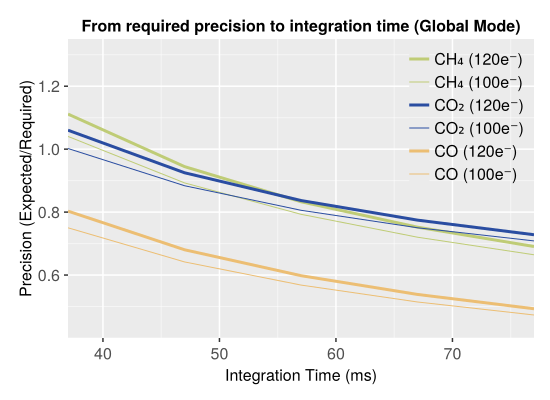

In [20]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Integration Time (ms)", ylabel="Precision (Expected/Required)",  title="From required precision to integration time (Global Mode)")
# For CH4 (100 and 120e-)
lines!(ax, integrations, gas_errors_integration_120[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=3, label="CH₄ (120e⁻)")
lines!(ax, integrations, gas_errors_integration_100[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=1, label="CH₄ (100e⁻)")
# For CO2 (100 and 120e-)
lines!(ax, integrations, gas_errors_integration_120[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=3, label="CO₂ (120e⁻)")
lines!(ax, integrations, gas_errors_integration_100[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=1, label="CO₂ (100e⁻)")
# For CO (100 and 120e-)
lines!(ax, integrations, gas_errors_integration_120[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=3, label="CO (120e⁻)")
lines!(ax, integrations, gas_errors_integration_100[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=1, label="CO (100e⁻)")

xlims!(ax,37,77)
ylims!(ax,0.4,1.35)
axislegend(ax,position = :rt)
save("../../plots/final/SensitivityStudy_integration.pdf",f)
f

### The End